# Differential drive robot (i.e., "segbot") in artificial gravity

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `bumpy` (`True` or `False`) is whether or not the station is "bumpy".

In [2]:
simulator = ae353_segbot.Simulator(
    display=True,
    bumpy=False,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Create a slider to allow steering the robot.

In [3]:
slider = widgets.FloatSlider(
    value=0.,
    min=-3.,
    max=3.,
    step=0.01,
    description='Centerline:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='75%', border='solid 2px', margin='10px')
)

Choose a camera view from the following options:
* `camera_sideview()`
* `camera_backview()`
* `camera_wideview()`

In [4]:
simulator.camera_backview()

## DA MATH

In [5]:
import sympy as sym
import numpy as np
from scipy import linalg
from scipy import signal
import random

## EQs of Motion, F, Equilibrium, A, B

In [30]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_R,
 tau_L) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [f]])

phi, phidot = sym.symbols('phi, phidot')
fnew = sym.Matrix([[f[0]], [f[1]], [f[2]], [f[3]], [phi], [f[4]]])

taul, taur = sym.symbols('taul, taur')

e_le = 0
e_he = 0 # angle
ve = 2
we = 0
phie = 0 # angle
phidote = 0
tau_Re = 0
tau_Le = 0

A_num = sym.lambdify((e_l,e_h, v, w, theta, thetadot, tau_L, tau_R), fnew.jacobian([e_l, e_h, v, w, theta, thetadot]))
B_num = sym.lambdify((e_l,e_h, v, w, theta, thetadot, tau_L, tau_R), fnew.jacobian([tau_L, tau_R]))

A = A_num(e_le, e_he, ve, we, phie, phidote, tau_Re, tau_Le)
B = B_num(e_le, e_he, ve, we, phie, phidote, tau_Re, tau_Le)

A = A.astype(float)
B = B.astype(float)

A, B, A.shape, B.shape

(array([[   0.        ,    2.        ,    0.        ,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    1.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
         -125.        ,   -0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,   -0.        ,
          541.66666667,   -0.        ]]),
 array([[  0.        ,   0.        ],
        [  0.        ,   0.        ],
        [ 12.07264957,  12.07264957],
        [ -1.05014439,   1.05014439],
        [  0.        ,   0.        ],
        [-51.46011396, -51.46011396]]),
 (6, 6),
 (6, 2))

## Finding K

In [31]:
A[4][5] = 1
Am = sym.Matrix(A)
Bm = sym.Matrix(B)

def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K

Am, Bm

(Matrix([
 [0, 2.0, 0,   0,                0,   0],
 [0,   0, 0, 1.0,                0,   0],
 [0,   0, 0,   0,           -125.0,   0],
 [0,   0, 0,   0,                0,   0],
 [0,   0, 0,   0,                0, 1.0],
 [0,   0, 0,   0, 541.666666666667,   0]]),
 Matrix([
 [                0,                0],
 [                0,                0],
 [ 12.0726495726496, 12.0726495726496],
 [-1.05014439485429, 1.05014439485429],
 [                0,                0],
 [ -51.460113960114, -51.460113960114]]))

## Q Matrix Depiction

In [32]:
q1, q2, q3, q4, q5, q6 = sym.symbols('Q_1, Q_2, Q_3, Q_4, Q_5, Q_6')
Qs = np.diag([q1, q2, q3, q4, q5, q6])
Qs = sym.Matrix(Qs)
Qs

Matrix([
[Q_1,   0,   0,   0,   0,   0],
[  0, Q_2,   0,   0,   0,   0],
[  0,   0, Q_3,   0,   0,   0],
[  0,   0,   0, Q_4,   0,   0],
[  0,   0,   0,   0, Q_5,   0],
[  0,   0,   0,   0,   0, Q_6]])

## Q and R Matrix, LQR

In [66]:
Q1 = 1
Q2 = 2.05
Q3 = 1
Q4 = 2.05
Q5 = 3
Q6 = 2


Q = np.diag([Q1, Q2, Q3, Q4, Q5, Q6])
#Q = np.diag([5e3, 10e3, 0.1, 50, 3000, 200])
R = np.eye(2)

lqr_ans = lqr(A, B, Q, R)
lqr_ans

#k = np.array([[50, 83.958, -0.2236, 10.244, -44.468, -10.096], [-50, -83.958, -0.2236, -10.244, -44.468, -10.096]])

s = linalg.eigvals(A-B@k)

Kr = signal.place_poles(A, B, s).gain_matrix
lqr_ans

array([[ -0.70710678,  -2.49875246,  -0.70710678,  -1.84511166,
        -11.00381561,  -1.28004804],
       [  0.70710678,   2.49875246,  -0.70710678,   1.84511166,
        -11.00381561,  -1.28004804]])

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to both the right and left wheels. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [68]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # FIXME: replace the following lines
        
        k = np.array(lqr_ans)
        #k = np.array([[50, 83.958, -0.2236, 10.244, -44.468, -10.096], [-50, -83.958, -0.2236, -10.244, -44.468, -10.096]])
        x = np.array([[lateral_error], [heading_error], [forward_speed], [turning_rate], [pitch_angle], [pitch_rate]])
        
        u = -k@x
        
        right_wheel_torque = u[0][0]
        left_wheel_torque = u[1][0]
        
        return right_wheel_torque, left_wheel_torque

Create an instance of the controller.

In [74]:
controller = Controller()

Reset the simulator with given initial conditions. You may also change the angular velocity of the station if you like, but - beware! - doing so will change the amount of artificial gravity.

In [75]:
simulator.reset(
    initial_speed=1.,
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity=-0.5,
)

Reset the controller.

In [76]:
controller.reset()



Reset the slider.

In [77]:
slider.value = 0.

Run the simulator with steering. Note that this function runs **asynchronously** to allow user input. You **must** wait until the simulator finishes running before doing anything else in the notebook.

In [78]:
# Show the slider, to allow steering the robot
display(slider)

# Run the simulation asynchronously, to allow using the slider
obj = asyncio.ensure_future(
    simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=5.,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
        slider=slider,        # <-- optional (allow steering)
        print_debug=True,     # <-- optional (say when the simulator has finished running)
    )
)

FloatSlider(value=0.0, description='Centerline:', layout=Layout(border_bottom='solid 2px', border_left='solid …

Get results of running the simulator with steering.

In [80]:
if obj.done():
    data = obj.result()
else:
    print('You cannot get results until after the simulator is done running.')

Run the simulator with no steering.

In [63]:
data = await simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
    slider=None,          # <-- optional (allow no steering)
)


Get, show, and save a snapshot of the simulation after the last time step.

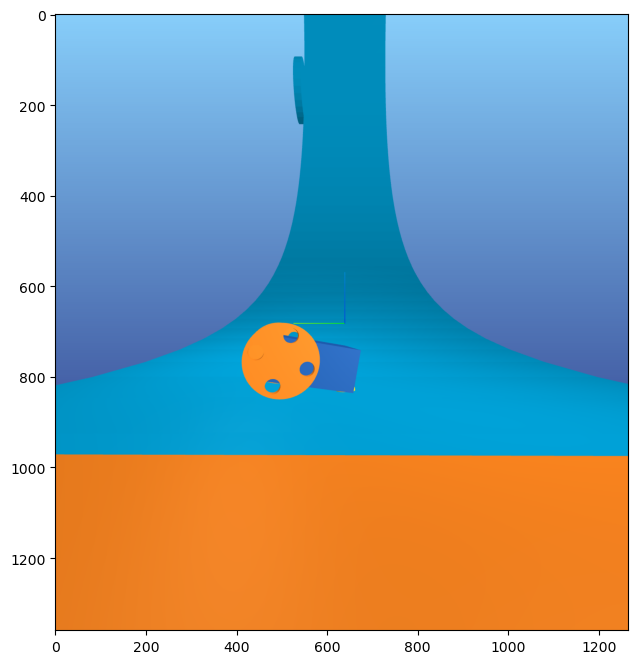

In [81]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

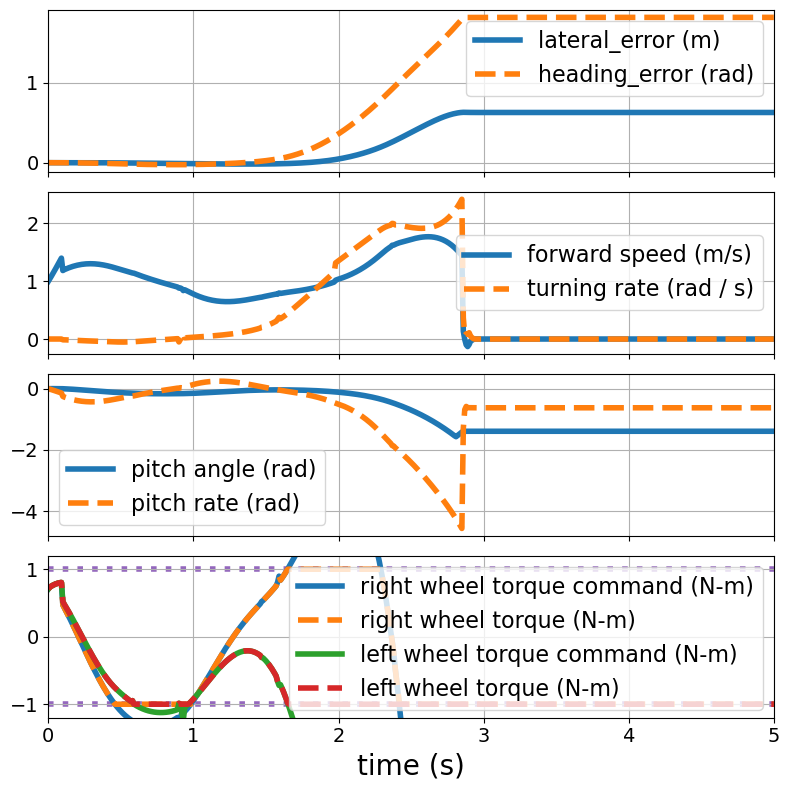

In [82]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

In [ ]:
data['pitch_angle'][500]

Save the figure (without transparent background).

In [907]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

## Automate Somehow??

In [317]:
findingK = [[0,0]] * 500
for x in range(500):
    
    # setting Q, LQR for K
    Q1 = 10e3 * random.uniform(0,1)
    Q2 = 10e3 * random.uniform(0,1)
    Q3 = 1500 * random.uniform(0,1)
    Q4 = 50 * random.uniform(0,1)
    Q5 = 3.5e3 * random.uniform(0,1)
    Q6 = 5e3 * random.uniform(0,1)


    Q = np.diag([Q1, Q2, Q3, Q4, Q5, Q6])
    R = np.eye(2)

    lqr_k = lqr(A, B, Q, R)
    
    if x == 499:
        Q1 = 5e3
        Q2 = 10e3
        Q3 = 0.1
        Q4 = 50
        Q5 = 3e3
        Q6 = 200


        Q = np.diag([Q1, Q2, Q3, Q4, Q5, Q6])
        R = np.eye(2)

        lqr_k = lqr(A, B, Q, R)
    
    # running sim code with K
    class Controller:
        def __init__(self):
            pass
    
        def reset(self):
            pass
    
        def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # FIXME: replace the following lines
        
            k = lqr_k
            x = np.array([[lateral_error], [heading_error], [forward_speed], [turning_rate], [pitch_angle], [pitch_rate]])
        
            u = -k@x
        
            right_wheel_torque = u[0][0]
            left_wheel_torque = u[1][0]
        
            return right_wheel_torque, left_wheel_torque
    
    controller = Controller()
    slider.value = 0.

    # Run the simulation asynchronously, to allow using the slider
    obj = asyncio.ensure_future(
    simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
        slider=slider,        # <-- optional (allow steering)
        print_debug=True,     # <-- optional (say when the simulator has finished running)
        )
    )
    if obj.done():
        data = obj.result()
    
    data = await simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
        slider=None,          # <-- optional (allow no steering)
    )
    
    lastdata = data['pitch_angle'][500]
    
    findingK[x] = [lqr_k, lastdata]
    

Simulated 501 time steps in 0.1223 seconds (4096.8545 time steps per second)
Simulated 501 time steps in 0.1385 seconds (3617.4226 time steps per second)
Simulated 501 time steps in 0.1386 seconds (3613.7584 time steps per second)
Simulated 501 time steps in 0.1345 seconds (3723.8634 time steps per second)
Simulated 501 time steps in 0.1217 seconds (4117.1223 time steps per second)
Simulated 501 time steps in 0.1409 seconds (3555.2587 time steps per second)
Simulated 501 time steps in 0.1487 seconds (3369.1079 time steps per second)
Simulated 501 time steps in 0.1422 seconds (3522.8230 time steps per second)
Simulated 501 time steps in 0.1378 seconds (3636.2707 time steps per second)
Simulated 501 time steps in 0.1389 seconds (3607.1580 time steps per second)
Simulated 501 time steps in 0.1371 seconds (3655.0811 time steps per second)
Simulated 501 time steps in 0.1394 seconds (3594.3613 time steps per second)
Simulated 501 time steps in 0.1376 seconds (3640.9078 time steps per second)

Simulated 501 time steps in 0.1634 seconds (3066.9559 time steps per second)
Simulated 501 time steps in 0.1843 seconds (2717.9974 time steps per second)
Simulated 501 time steps in 0.2121 seconds (2362.1037 time steps per second)
Simulated 501 time steps in 0.1889 seconds (2652.8533 time steps per second)
Simulated 501 time steps in 0.1831 seconds (2736.1743 time steps per second)
Simulated 501 time steps in 0.1645 seconds (3045.3632 time steps per second)
Simulated 501 time steps in 0.1582 seconds (3167.4831 time steps per second)
Simulated 501 time steps in 0.1855 seconds (2700.4976 time steps per second)
Simulated 501 time steps in 0.2487 seconds (2014.6190 time steps per second)
Simulated 501 time steps in 0.1819 seconds (2754.3432 time steps per second)
Simulated 501 time steps in 0.1517 seconds (3302.3161 time steps per second)
Simulated 501 time steps in 0.1369 seconds (3660.8438 time steps per second)
Simulated 501 time steps in 0.1605 seconds (3121.4016 time steps per second)

Simulated 501 time steps in 0.1848 seconds (2710.9633 time steps per second)
Simulated 501 time steps in 0.1722 seconds (2909.0780 time steps per second)
Simulated 501 time steps in 0.1729 seconds (2897.5215 time steps per second)
Simulated 501 time steps in 0.1737 seconds (2883.7038 time steps per second)
Simulated 501 time steps in 0.1688 seconds (2967.9655 time steps per second)
Simulated 501 time steps in 0.1818 seconds (2755.1666 time steps per second)
Simulated 501 time steps in 0.1810 seconds (2767.5877 time steps per second)
Simulated 501 time steps in 0.1761 seconds (2844.6584 time steps per second)
Simulated 501 time steps in 0.1752 seconds (2859.0601 time steps per second)
Simulated 501 time steps in 0.1686 seconds (2971.0960 time steps per second)
Simulated 501 time steps in 0.1758 seconds (2849.5111 time steps per second)
Simulated 501 time steps in 0.1723 seconds (2908.1077 time steps per second)
Simulated 501 time steps in 0.1820 seconds (2753.4987 time steps per second)

Simulated 501 time steps in 0.1777 seconds (2818.8094 time steps per second)
Simulated 501 time steps in 0.1697 seconds (2952.9922 time steps per second)
Simulated 501 time steps in 0.1702 seconds (2943.1898 time steps per second)
Simulated 501 time steps in 0.1717 seconds (2917.9165 time steps per second)
Simulated 501 time steps in 0.1807 seconds (2771.9541 time steps per second)
Simulated 501 time steps in 0.1672 seconds (2996.1963 time steps per second)
Simulated 501 time steps in 0.1775 seconds (2822.0499 time steps per second)
Simulated 501 time steps in 0.1754 seconds (2856.4252 time steps per second)
Simulated 501 time steps in 0.1748 seconds (2865.7315 time steps per second)
Simulated 501 time steps in 0.1718 seconds (2915.6614 time steps per second)
Simulated 501 time steps in 0.1782 seconds (2810.8197 time steps per second)
Simulated 501 time steps in 0.1679 seconds (2984.0700 time steps per second)
Simulated 501 time steps in 0.1730 seconds (2895.5850 time steps per second)

Simulated 501 time steps in 0.1743 seconds (2874.8468 time steps per second)
Simulated 501 time steps in 0.1690 seconds (2965.1554 time steps per second)
Simulated 501 time steps in 0.1687 seconds (2969.2362 time steps per second)
Simulated 501 time steps in 0.1667 seconds (3005.2462 time steps per second)
Simulated 501 time steps in 0.1673 seconds (2994.3903 time steps per second)
Simulated 501 time steps in 0.1667 seconds (3004.8079 time steps per second)
Simulated 501 time steps in 0.1851 seconds (2706.0758 time steps per second)
Simulated 501 time steps in 0.1758 seconds (2850.1333 time steps per second)
Simulated 501 time steps in 0.1696 seconds (2954.5741 time steps per second)
Simulated 501 time steps in 0.1683 seconds (2977.2715 time steps per second)
Simulated 501 time steps in 0.1665 seconds (3008.9772 time steps per second)
Simulated 501 time steps in 0.1684 seconds (2975.5893 time steps per second)
Simulated 501 time steps in 0.1754 seconds (2857.0932 time steps per second)

In [318]:
findingK

[[array([[-11.12457852, -57.09623676, -17.2000448 ,  -7.97314598,
          -60.10057849, -26.90416797],
         [ 11.12457852,  57.09623676, -17.2000448 ,   7.97314598,
          -60.10057849, -26.90416797]]),
  1.390340565446668],
 [array([[-67.270923  , -85.1828282 , -14.82139135, -10.26677811,
          -71.22988673, -45.59706965],
         [ 67.270923  ,  85.1828282 , -14.82139135,  10.26677811,
          -71.22988673, -45.59706965]]),
  1.3903707943824635],
 [array([[-38.2644897 , -46.88854343, -26.49909174,  -7.21486929,
          -84.41388319, -53.7527043 ],
         [ 38.2644897 ,  46.88854343, -26.49909174,   7.21486929,
          -84.41388319, -53.7527043 ]]),
  1.3903878625319122],
 [array([[-54.00329474, -56.17934239, -15.69239712,  -8.76878296,
          -67.46140343, -35.10937132],
         [ 54.00329474,  56.17934239, -15.69239712,   8.76878296,
          -67.46140343, -35.10937132]]),
  1.3907413984384567],
 [array([[-65.42590552, -72.65048392, -25.99007886,  -9.53442

In [319]:
count = 0
for l in findingK:
    if l[1] < 1e-2 and l[1] > -1e-2:
        print(l[0])
    count += 1
    if (count == len(findingK)):
        print("massive L")


massive L


In [320]:
1e-2

0.01